In [ ]:
import matplotlib, sys
print("Matplotlib:", matplotlib.__file__)
print("Python:", sys.executable)



Matplotlib: /home/fljv/ur5e_plot_env/lib/python3.10/site-packages/matplotlib/__init__.py
Python: /home/fljv/ur5e_plot_env/bin/python


In [ ]:
import sys
from pathlib import Path
root = Path().resolve()
for candidate in (root, *root.parents):
    if (candidate / "src").exists():
        if str(candidate) not in sys.path:
            sys.path.insert(0, str(candidate))
        break
from lemniscate import lemniscate


DMP log:    5342 samples
MoveIt log: 2691 samples
Estimated DMP dt ≈ 0.02000 s, duration ≈ 106.820 s
Estimated MV  dt ≈ 0.02000 s, duration ≈ 53.800 s
Using common window T = 53.800 s and dt ≈ 0.02000 s
Reference samples: 2691
DMP overlapping samples:    2690
MoveIt overlapping samples: 2691
Using N = 2690 aligned samples for comparison.


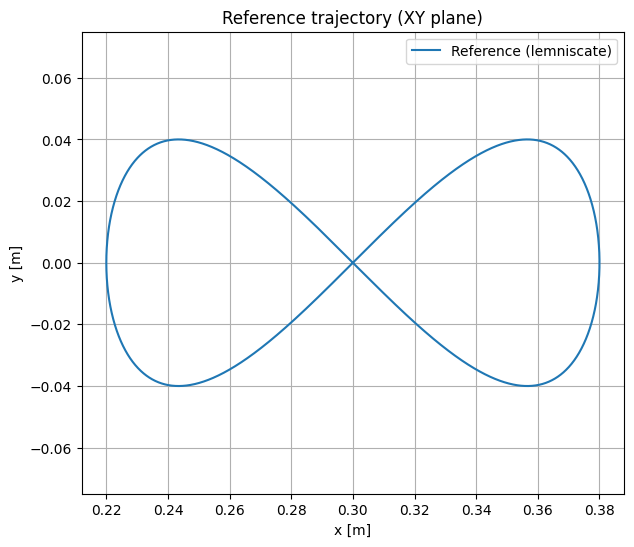

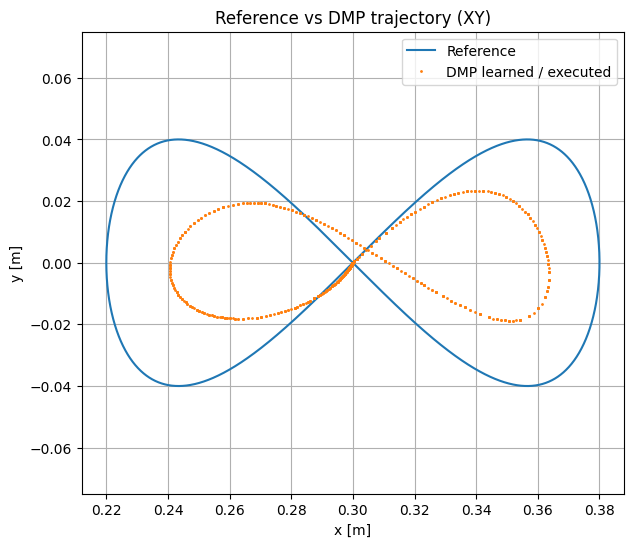

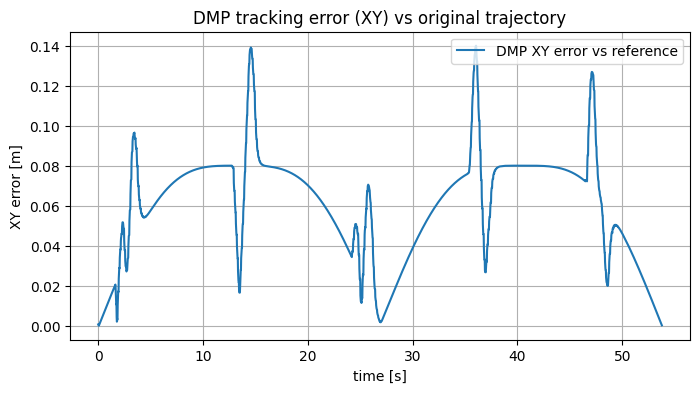

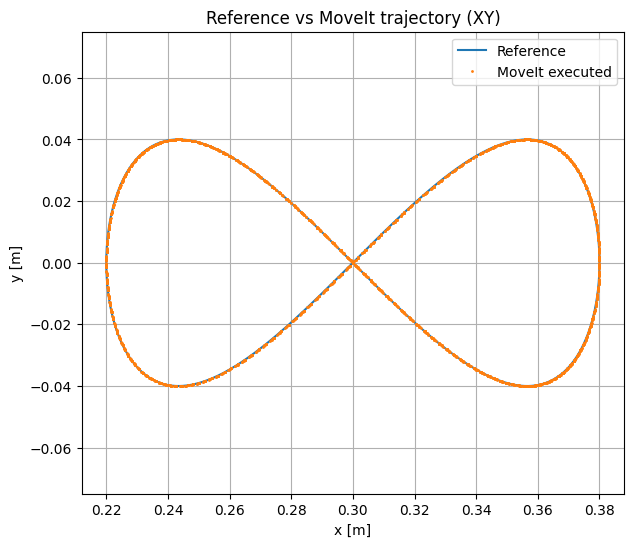

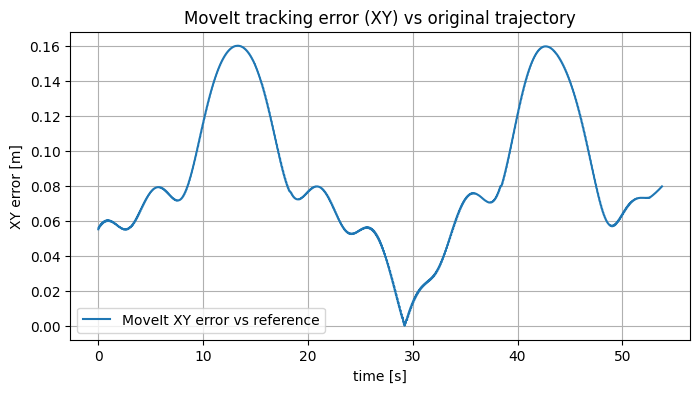

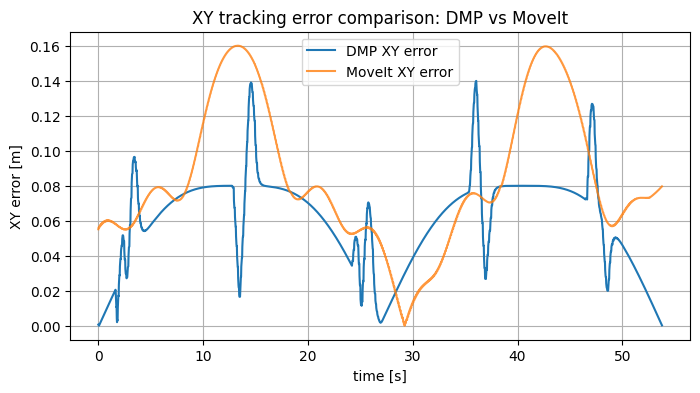


=== Error statistics (XY distance to reference) ===
DMP:
  RMS   : 0.066376 m
  mean  : 0.060639 m
  median: 0.068776 m
  std   : 0.027001 m
  max   : 0.139895 m
  p95   : 0.093880 m

MoveIt:
  RMS   : 0.093021 m
  mean  : 0.083967 m
  median: 0.074010 m
  std   : 0.040038 m
  max   : 0.160000 m
  p95   : 0.157935 m

=== Paired t-test on XY error (MoveIt vs DMP) ===
t statistic: 35.5528
p value    : 2.8245e-227
Result: difference is statistically significant at alpha=0.05.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try SciPy for stats tests (optional)
try:
    from scipy import stats
    HAVE_SCIPY = True
except ImportError:
    HAVE_SCIPY = False

def describe_errors(err):
    err = np.asarray(err)
    return {
        "RMS": float(np.sqrt(np.mean(err**2))),
        "mean": float(np.mean(err)),
        "median": float(np.median(err)),
        "std": float(np.std(err, ddof=1)),
        "max": float(np.max(err)),
        "p95": float(np.percentile(err, 95)),
    }

df_dmp = pd.read_csv("/home/fljv/pai_ws/ee_logs/ee_traj_dmp.csv")       # DMP executed EE trajectory
df_mv  = pd.read_csv("/home/fljv/pai_ws/ee_logs/ee_traj_moveit.csv")    # MoveIt executed EE trajectory

print(f"DMP log:    {len(df_dmp)} samples")
print(f"MoveIt log: {len(df_mv)} samples")

# Relative time (start at 0)
for df in (df_dmp, df_mv):
    df["t_rel"] = df["t"] - df["t"].iloc[0]

dt_d = float(np.median(np.diff(df_dmp["t_rel"])))
dt_m = float(np.median(np.diff(df_mv["t_rel"])))
T_d  = float(df_dmp["t_rel"].iloc[-1])
T_m  = float(df_mv["t_rel"].iloc[-1])

print(f"Estimated DMP dt ≈ {dt_d:.5f} s, duration ≈ {T_d:.3f} s")
print(f"Estimated MV  dt ≈ {dt_m:.5f} s, duration ≈ {T_m:.3f} s")

# Use a common time window + dt for fair comparison
dt_common = min(dt_d, dt_m)
T_common  = min(T_d, T_m)

print(f"Using common window T = {T_common:.3f} s and dt ≈ {dt_common:.5f} s")

t_ref, pos_ref, vel_ref, pitch_ref, dt_ref = lemniscate(
    T=T_common,
    dt=dt_common,
    a=0.08,
    center=(0.30, 0.0, 0.50),
    close_loop=False,
    rock_z_amp=0.01,
    rock_pitch_amp_deg=8.0,
    rock_phase_mult=1.0,
)

x_ref = pos_ref[:, 0]
y_ref = pos_ref[:, 1]
z_ref = pos_ref[:, 2]

print(f"Reference samples: {len(t_ref)}")

mask_d = df_dmp["t_rel"] <= T_common
mask_m = df_mv["t_rel"]  <= T_common

t_d = df_dmp.loc[mask_d, "t_rel"].to_numpy()
x_d = df_dmp.loc[mask_d, "x"].to_numpy()
y_d = df_dmp.loc[mask_d, "y"].to_numpy()
z_d = df_dmp.loc[mask_d, "z"].to_numpy()

t_m = df_mv.loc[mask_m, "t_rel"].to_numpy()
x_m = df_mv.loc[mask_m, "x"].to_numpy()
y_m = df_mv.loc[mask_m, "y"].to_numpy()
z_m = df_mv.loc[mask_m, "z"].to_numpy()

print(f"DMP overlapping samples:    {len(t_d)}")
print(f"MoveIt overlapping samples: {len(t_m)}")

N = min(len(t_ref), len(t_d), len(t_m))
t_ref = t_ref[:N]
x_ref, y_ref, z_ref = x_ref[:N], y_ref[:N], z_ref[:N]

t_d, x_d, y_d, z_d = t_d[:N], x_d[:N], y_d[:N], z_d[:N]
t_m, x_m, y_m, z_m = t_m[:N], x_m[:N], y_m[:N], z_m[:N]

print(f"Using N = {N} aligned samples for comparison.")

plt.figure(figsize=(7, 6))
plt.plot(x_ref, y_ref, "-", label="Reference (lemniscate)")
plt.axis("equal")
plt.grid(True)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Reference trajectory (XY plane)")
plt.legend()
plt.show()

plt.figure(figsize=(7, 6))
plt.plot(x_ref, y_ref, "-", label="Reference")
plt.plot(x_d,   y_d,   ".", markersize=2, label="DMP learned / executed")
plt.axis("equal")
plt.grid(True)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Reference vs DMP trajectory (XY)")
plt.legend()
plt.show()

err_dmp_xy = np.sqrt((x_d - x_ref)**2 + (y_d - y_ref)**2)

plt.figure(figsize=(8, 4))
plt.plot(t_ref, err_dmp_xy, label="DMP XY error vs reference")
plt.xlabel("time [s]")
plt.ylabel("XY error [m]")
plt.grid(True)
plt.legend()
plt.title("DMP tracking error (XY) vs original trajectory")
plt.show()

plt.figure(figsize=(7, 6))
plt.plot(x_ref, y_ref, "-", label="Reference")
plt.plot(x_m,   y_m,   ".", markersize=2, label="MoveIt executed")
plt.axis("equal")
plt.grid(True)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Reference vs MoveIt trajectory (XY)")
plt.legend()
plt.show()

err_mv_xy = np.sqrt((x_m - x_ref)**2 + (y_m - y_ref)**2)

plt.figure(figsize=(8, 4))
plt.plot(t_ref, err_mv_xy, label="MoveIt XY error vs reference")
plt.xlabel("time [s]")
plt.ylabel("XY error [m]")
plt.grid(True)
plt.legend()
plt.title("MoveIt tracking error (XY) vs original trajectory")
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(t_ref, err_dmp_xy, label="DMP XY error")
plt.plot(t_ref, err_mv_xy,  label="MoveIt XY error", alpha=0.8)
plt.xlabel("time [s]")
plt.ylabel("XY error [m]")
plt.grid(True)
plt.legend()
plt.title("XY tracking error comparison: DMP vs MoveIt")
plt.show()

stats_dmp = describe_errors(err_dmp_xy)
stats_mv  = describe_errors(err_mv_xy)

print("\n=== Error statistics (XY distance to reference) ===")
print("DMP:")
for k, v in stats_dmp.items():
    print(f"  {k:6s}: {v:.6f} m")

print("\nMoveIt:")
for k, v in stats_mv.items():
    print(f"  {k:6s}: {v:.6f} m")

if HAVE_SCIPY:
    t_stat, p_val = stats.ttest_rel(err_mv_xy, err_dmp_xy)
    print("\n=== Paired t-test on XY error (MoveIt vs DMP) ===")
    print(f"t statistic: {t_stat:.4f}")
    print(f"p value    : {p_val:.4e}")
    if p_val < 0.05:
        print("Result: difference is statistically significant at alpha=0.05.")
    else:
        print("Result: no statistically significant difference at alpha=0.05.")
else:
    print("\nSciPy not available -> skipping formal t-test.")
    print("You still have RMS / mean / std / max / p95 for comparison.")
